In [2]:
import numpy as np
import cv2
import random
import os

In [3]:
img = cv2.imread("/mnt/c/Users/Siddhant/Desktop/yolov5-custom-usecases/sample_vechile_det_dataset/train/images/"+ 'f98d3ab7-be00-4c1a-971e-4c530c547780.jpg')
annotation = np.genfromtxt("/mnt/c/Users/Siddhant/Desktop/yolov5-custom-usecases/sample_vechile_det_dataset/train/labels/"+ 'f98d3ab7-be00-4c1a-971e-4c530c547780' + '.txt', delimiter=" ")

img = cv2.resize(img, [420,390])
# Extract segmentation information
class_id, points = annotation[0], annotation[1:]

# Convert normalized coordinates to absolute values
height, width = img.shape[:2]
points[::2] 
points[1::2] 

labels =np.array([[0, 0.4844, 0.49538     ,0.62912     ,0.63395]])

# Convert points to integers and reshape to (n, 2) array
points = points.reshape(-1, 2)
segments_ori = [points]

In [4]:

# # img = cv2.imread("./sample_vechile_det_dataset/train/images/17e5b483-7482-4977-919f-e9704a3f5cd0.jpg")
# img = cv2.imread("./sample_vechile_det_dataset/train/images/17e5b483-7482-4977-919f-e9704a3f5cd0.jpg")
# image_height, image_width = img.shape[:2]
# labels = np.array([[0, 0.50716, 0.49336, 0.93099, 0.96132]])
# segments_ori = [
#     np.array(
#        [[    0.97266,     0.51617],
#        [    0.94922,     0.46478],
#        [    0.94748,     0.37182],
#        [    0.91797,     0.33372],
#        [      0.898,      0.2448],
#        [    0.87804,     0.19861],
#        [    0.81207,     0.13453],
#        [    0.67925,     0.10797],
#        [     0.7079,    0.012702],
#        [    0.67708,    0.093534],
#        [    0.65842,     0.11028],
#        [    0.41971,     0.10624],
#        [    0.32118,     0.11547],
#        [     0.2296,     0.14319],
#        [    0.19097,     0.17552],
#        [    0.14236,     0.24018],
#        [    0.11415,     0.29388],
#        [   0.099826,     0.28176],
#        [   0.062934,     0.28637],
#        [   0.055556,     0.29677],
#        [   0.057292,     0.33025],
#        [   0.049045,     0.33718],
#        [   0.041667,     0.37125],
#        [   0.045139,     0.44169],
#        [   0.072917,     0.55196],
#        [    0.08724,     0.58083],
#        [     0.1224,     0.58545],
#        [    0.15321,     0.55601],
#        [    0.42144,     0.73441],
#        [    0.42708,     0.81236],
#        [    0.45139,     0.88106],
#        [    0.49306,      0.9463],
#        [    0.54688,     0.97402],
#        [    0.59679,     0.96016],
#        [    0.62109,      0.9336],
#        [    0.63715,      0.8955],
#        [    0.69965,     0.90012],
#        [     0.7322,      0.8903],
#        [    0.78733,     0.85393],
#        [    0.87413,     0.77021],
#        [    0.93359,     0.68764],
#        [    0.97092,      0.5485]]
#     )
# ]

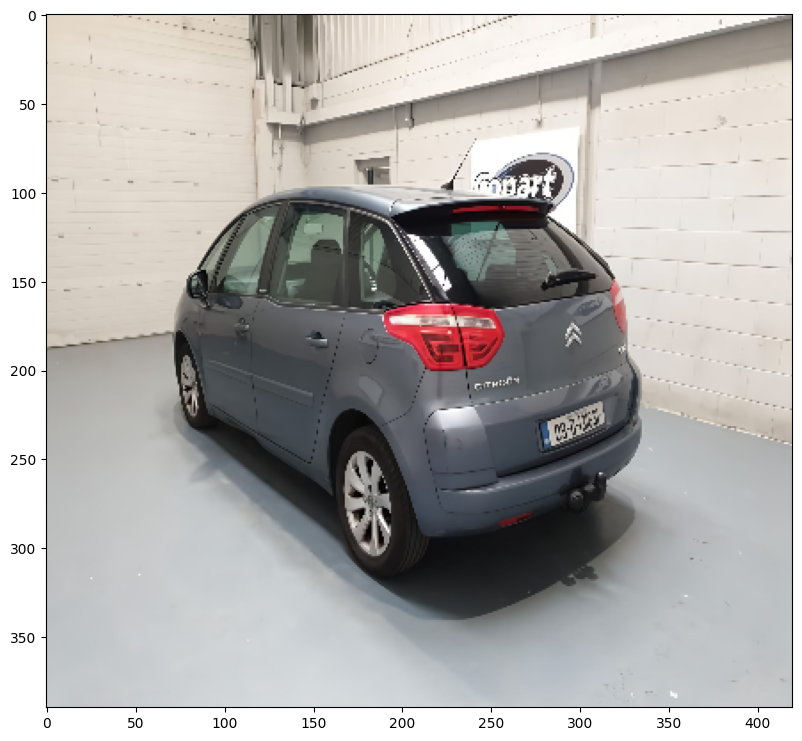

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.imshow(img[:,:,::-1], cmap='gray')

In [6]:
import random

my_list = [[256,480,640,720, 1080],[256,480,640,720, 1080]]

width = random.choice(my_list[0])
height = random.choice(my_list[1])

In [7]:
print(width,height)

640 640


In [8]:
from imantics import Polygons, Mask
import random
import copy


class PreAlbumentations:
    ## ONLY SUPPORT ONE OBJECT PER IMAGE FOR NOW
    
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, margin=0.1):
        self.transform = None
        # prefix = colorstr('pre load albumentations: ')
        try:
            import albumentations as A
            # check_version(A.__version__, '1.0.3', hard=True)  # version requirement
            
            # define margin for partial car
            self.margin = margin
            
            list_for_size = [256,480,640,720,1080]

            rand_size = random.choice(list_for_size)
            # define transforms for partial visible objects
            self.transforms_partial = A.Compose(
                [
                    A.Resize(height=1920, width=1080, always_apply=True),
                    # A.RandomResizedCrop(height=640, width=1080, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=1.0),
                    A.RandomCrop(width=rand_size, height=rand_size, p=1.0)

                ], 
                bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
            )
            
            # define transforms for completely visible object
            self.transforms_commplete = A.Compose(
                [
                    A.Resize(height=1920, width=1080, always_apply=True),
                    A.RandomResizedCrop(height=rand_size, width=rand_size, scale=(0.1, 0.5), ratio=(0.9, 1.11), p=1.0),
                    # A.RandomCrop(width=rand_width, height=rand_height, p=1.0)
                ], 
                bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
            )

            # LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        except ImportError:  # package not installed, skip
            pass
        # except Exception as e:
            #LOGGER.info(f'{prefix}{e}')

    def __call__(self, im, labels, segments, probability_partial=0.05, probability_complete=0.5):
        if len(segments) > 1 or labels.shape[0] > 1:
            raise ValueError("multiple object per image are not supported yet")
        
        # get image height and width
        image_height, image_width = im.shape[:2]
        
        # check if image is partial or full
        # xi1, xi2, yi1, yi2 = self.margin, (1-self.margin), self.margin, (1-self.margin)
        # xb1, xb2, yb1, yb2 = xc-(w/2), w+xc-(w/2), yc-(h/2), h+yc-(h/2)
        
        # get bbox co-ordinates
        xc, yc, w, h = labels[0, 1:]
        
        partial_object = False
        if xc-w/2 < self.margin and \
            w+xc-w/2 > (1-self.margin) and \
            yc-h/2 < self.margin and \
            h+yc-h/2 > (1-self.margin):   
            partial_object = True
        
        
        # convert segments to mask
        segments_denorm = segments.copy()
        # if np.any(segments[0] < 1.2):
        #     segments_denorm = []
        #     for segment_ in segments:
        #         segment_[:, 0] *= image_width
        #         segment_[:, 1] *= image_height
        #         segments_denorm.append(segment_)

        # print(segments_denorm)
        
        # apply augmentation for partial object
        if self.transforms_partial and random.random() < probability_partial and partial_object == True:
             # create mask
            mask = Polygons(segments_denorm).mask(width=image_width, height=image_height)
            
            new = self.transforms_partial(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0], mask=np.array(mask.array, dtype=np.uint8))
            new_im, new_labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
            segments_norm = []
            for new_segment in Mask(new['mask']).polygons().points:
                new_segment = new_segment.astype(np.float64)
                new_segment[:, 0] /= new_im.shape[1]
                new_segment[:, 1] /= new_im.shape[0]
                segments_norm.append(new_segment)
            
            if len(segments_norm) == 1 and labels.shape[0]== 1:
                return new_im, new_labels, segments_norm
            
        # apply augmentation for complete object
        if self.transforms_commplete and random.random() < probability_complete and partial_object == False:
            # create mask
            mask = Polygons(segments_denorm).mask(width=image_width, height=image_height)
            new = self.transforms_commplete(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0], mask=np.array(mask.array, dtype=np.uint8))
            new_im, new_labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
            segments_norm = []
            for new_segment in Mask(new['mask']).polygons().points:
                new_segment = new_segment.astype(np.float64)
                new_segment[:, 0] /= new_im.shape[1]
                new_segment[:, 1] /= new_im.shape[0]
                segments_norm.append(new_segment)
            if len(segments_norm) == 1 and labels.shape[0]== 1:
                return new_im, new_labels, segments_norm
        
        return im, labels, segments        

In [25]:
a = PreAlbumentations(margin=0.01)


In [26]:
# a = PreAlbumentations(margin=0.1)

im_, labels_, mask_ = a(im=img, labels=labels, segments=segments_ori, probability_partial=1.0, probability_complete=1.0)


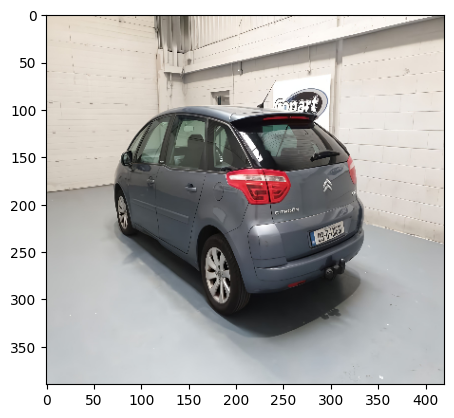

In [27]:
plt.imshow(im_[:,:,::-1], cmap='gray')

In [195]:
mask_[0][:, 0] *= im_.shape[1]
mask_[0][:, 1] *= im_.shape[0]

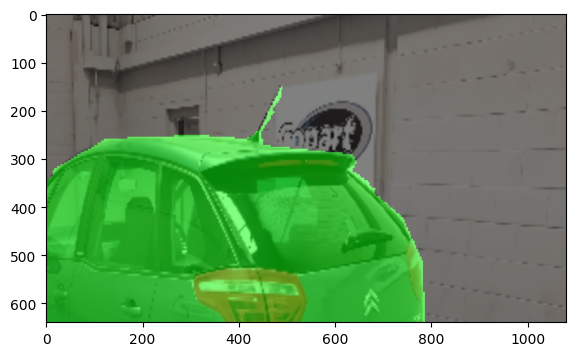

In [196]:
def plt_mask(img, mask_):
    image = img.copy()

    # Create an empty mask with the same size as the image
    mask = np.zeros_like(image)

    # Fill the polygon defined by the points with the color for the class
    color = (0, 255, 0) # green for class 0, adjust as needed
    cv2.fillPoly(mask, [mask_[0].astype(np.int32)], color)

    # Overlay the mask on the image using alpha blending
    alpha = 0.5 # adjust as needed
    overlay = cv2.addWeighted(image, 1-alpha, mask, alpha, 0)
    plt.figure(figsize=(9, 4))
    plt.imshow(overlay[:,:,::-1], cmap='gray')

plt_mask(im_, mask_)

In [190]:
segments_norm[0]

array([[  0.,   0.],
       [  0., 480.],
       [640., 480.],
       [640.,   0.]])

In [193]:
old_mask.astype(np.uint8)

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [118]:
old_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [151]:
mask_2_poly(old_mask)

[array([[[586,  78]]], dtype=int32)]

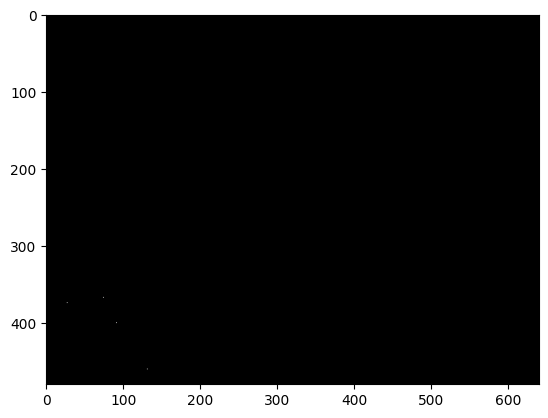

In [125]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_2_poly(mask):
    # Step 1: Read the mask image
    mask = mask.astype(np.uint8)
    # Step 2: Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Convert contours to polygons
    polygons = []
    for contour in contours:
        polygon = cv2.approxPolyDP(contour, epsilon=0.003, closed=True)
        polygons.append(polygon)
    return polygons
# Step 4: Visualize the polygons
image = np.zeros_like(mask)
for polygon in polygons:
    cv2.fillPoly(image, [polygon], color=255)

plt.imshow(image, cmap='gray')
plt.show()


In [75]:
polygons

[array([[[131, 460]]], dtype=int32),
 array([[[ 91, 400]]], dtype=int32),
 array([[[ 27, 374]]], dtype=int32),
 array([[[ 74, 367]]], dtype=int32)]

In [8]:
!python segment/val.py --img 480 --batch 8 --data './sample_vechile_det_dataset/data.yaml' --weights './runs/train-seg/exp22/weights/best.pt'

segment/val: data=./sample_vechile_det_dataset/data.yaml, weights=['./runs/train-seg/exp22/weights/best.pt'], batch_size=8, imgsz=480, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-120-g42cd233 Python-3.9.16 torch-1.10.1+cpu CPU

Fusing layers... 
Model summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
val: Scanning /mnt/c/Users/Siddhant/Desktop/yolov5-custom-usecases/sample_vechil
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         20         20      0.826        0.9      0.946      0.473      0.826        0.9      0.946      0.855
Speed: 1.9ms pre-process, 125.3ms inference, 30.5ms NMS per image at shape (8, 3, 480, 480)
Results saved to runs/val-seg/exp


In [30]:
!python segment/train.py --img 480 --batch 1 --epochs 5 --data './sample_vechile_det_dataset/data.yaml' --weights yolov5s-seg.pt

segment/train: weights=yolov5s-seg.pt, cfg=, data=./sample_vechile_det_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=1, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull ultralytics master' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-120-g42cd233 Python-3.9.16 torch-1.10.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.

In [ ]:
def plt_mask(mask_dir):
    # Load the image and annotation file
    image = cv2.imread("/mnt/c/Users/Siddhant/Desktop/yolov5-custom-usecases/sample_vechile_det_dataset/train/images/"+ mask_dir)
    annotation = np.genfromtxt("/mnt/c/Users/Siddhant/Desktop/yolov5-custom-usecases/sample_vechile_det_dataset/train/labels/"+ mask_dir[:-4] + '.txt', delimiter=" ")

    # Extract segmentation information
    class_id, points = annotation[0], annotation[1:]

    # Convert normalized coordinates to absolute values
    height, width = image.shape[:2]
    points[::2] *= width
    points[1::2] *= height


    # Convert points to integers and reshape to (n, 2) array
    points = np.int32(points.reshape(-1, 2))

    # Create an empty mask with the same size as the image
    mask = np.zeros_like(image)

    # Fill the polygon defined by the points with the color for the class
    color = (0, 255, 0) # green for class 0, adjust as needed
    cv2.fillPoly(mask, [points], color)

    # Overlay the mask on the image using alpha blending
    alpha = 0.5 # adjust as needed
    overlay = cv2.addWeighted(image, 1-alpha, mask, alpha, 0)

    # Display the resulting image
    cv2.imwrite('temp_mask/' + mask_dir , overlay)